In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_simple as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.roberta_conf


# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,['about','to','as'],model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,['about','to','as'],model_conf) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset(md_data,['about','to','as'],model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [14]:
learning_rate = 1e-6
num_epochs = 100
global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [15]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_about'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5615030389525749 	 Validation loss: 0.40676932213670114 	 
  1%|          | 574/57400 [02:05<2:45:08,  5.74it/s]
Epoch 2 	 Training loss: 0.40315572143847106 	 Validation loss: 0.3596042419894267 	 
  2%|▏         | 1148/57400 [04:09<2:45:29,  5.67it/s]
Epoch 3 	 Training loss: 0.36670292861993303 	 Validation loss: 0.3390847300573931 	 
  3%|▎         | 1722/57400 [06:13<3:15:50,  4.74it/s]
Epoch 4 	 Training loss: 0.34924658618945276 	 Validation loss: 0.33132575755402194 	 
  4%|▍         | 2296/57400 [08:15<2:36:36,  5.86it/s]
Epoch 5 	 Training loss: 0.33432154931153985 	 Validation loss: 0.3227032001240779 	 
  5%|▌         | 2870/57400 [10:17<2:52:19,  5.27it/s]
Epoch 6 	 Training loss: 0.32444051191054984 	 Validation loss: 0.316016473254915 	 
  6%|▌         | 3444/57400 [12:20<2:48:41,  5.33it/s]
Epoch 7 	 Training loss: 0.3152050328171627 	 Validation loss: 0.31266165890936126 	 
  7%|▋         | 4018/57400 [14:22<2:28:48,  5.98it/s]
Epoch 8 	 Trai

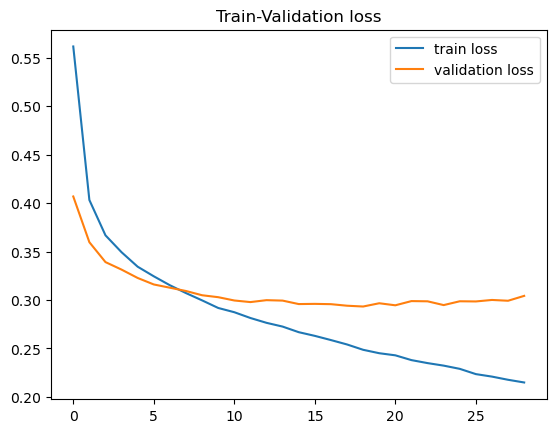

In [16]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8571428571428571, 'precision': 0.8571428571428571, 'f1': 0.8571428571428571, 'accuracy': 0.8571428571428571}
MALE {'recall': 0.8645833333333334, 'precision': 0.8645833333333334, 'f1': 0.8645833333333333, 'accuracy': 0.8645833333333334}
FEMALE {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7070707070707071, 'precision': 0.7070707070707071, 'f1': 0.7070707070707071, 'accuracy': 0.7070707070707071}
MALE {'recall': 0.7177615571776156, 'precision': 0.7177615571776156, 'f1': 0.7177615571776156, 'accuracy': 0.7177615571776156}
FEMALE {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6949152542372882, 'precision': 0.6949152542372882, 'f1': 0.6949152542372882, 'accuracy': 0.6949152542372882}
MALE {'recall': 0.699494

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5695204320996481 	 Validation loss: 0.39630124831603747 	 
  1%|          | 574/57400 [01:30<2:13:38,  7.09it/s]
Epoch 2 	 Training loss: 0.3991905902009392 	 Validation loss: 0.35245273527452503 	 
  2%|▏         | 1148/57400 [02:59<2:16:15,  6.88it/s]
Epoch 3 	 Training loss: 0.36628760675208494 	 Validation loss: 0.3338970014099347 	 
  3%|▎         | 1722/57400 [04:27<2:12:27,  7.01it/s]
Epoch 4 	 Training loss: 0.3484362274252579 	 Validation loss: 0.326623638807717 	 
  4%|▍         | 2296/57400 [05:57<2:13:31,  6.88it/s]
Epoch 5 	 Training loss: 0.3336241161158691 	 Validation loss: 0.3180142694105536 	 
  5%|▌         | 2870/57400 [07:26<2:21:45,  6.41it/s]
Epoch 6 	 Training loss: 0.3215643399580015 	 Validation loss: 0.3144099045608003 	 
  6%|▌         | 3444/57400 [08:57<2:07:28,  7.05it/s]
Epoch 7 	 Training loss: 0.3139200471990615 	 Validation loss: 0.3083969215720387 	 
  7%|▋         | 4018/57400 [10:29<2:18:11,  6.44it/s]
Epoch 8 	 Training 

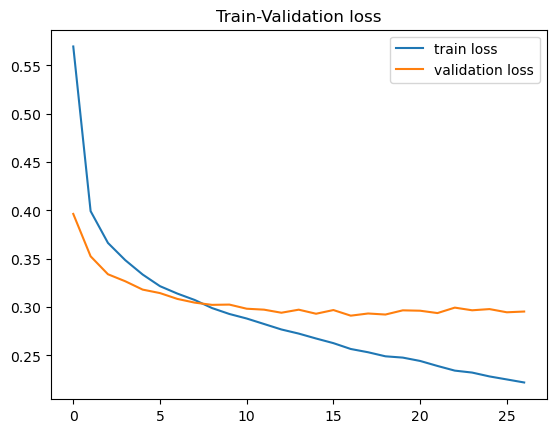

In [17]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8660714285714286, 'precision': 0.8660714285714286, 'f1': 0.8660714285714286, 'accuracy': 0.8660714285714286}
MALE {'recall': 0.8697916666666666, 'precision': 0.8697916666666666, 'f1': 0.8697916666666666, 'accuracy': 0.8697916666666666}
FEMALE {'recall': 0.8625, 'precision': 0.8625, 'f1': 0.8625, 'accuracy': 0.8625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6982323232323232, 'precision': 0.6982323232323232, 'f1': 0.6982323232323232, 'accuracy': 0.6982323232323232}
MALE {'recall': 0.7104622871046229, 'precision': 0.7104622871046229, 'f1': 0.7104622871046229, 'accuracy': 0.7104622871046229}
FEMALE {'recall': 0.6850393700787402, 'precision': 0.6850393700787402, 'f1': 0.6850393700787402, 'accuracy': 0.6850393700787402} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6975228161668839, 'precision': 0.6975228161668839, 'f1': 0.6975228161668839, 'accuracy': 0.6975228161668839}
MALE {'recall': 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5565924122150767 	 Validation loss: 0.4034890673928342 	 
  1%|          | 574/57400 [01:29<2:24:10,  6.57it/s]
Epoch 2 	 Training loss: 0.3955122391054024 	 Validation loss: 0.3544542804612952 	 
  2%|▏         | 1148/57400 [02:59<2:26:22,  6.40it/s]
Epoch 3 	 Training loss: 0.36422064999047055 	 Validation loss: 0.33748965344186554 	 
  3%|▎         | 1722/57400 [04:28<2:25:08,  6.39it/s]
Epoch 4 	 Training loss: 0.3466577995633414 	 Validation loss: 0.32490246654567073 	 
  4%|▍         | 2296/57400 [05:58<2:15:42,  6.77it/s]
Epoch 5 	 Training loss: 0.3320035000399845 	 Validation loss: 0.3200123153500638 	 
  5%|▌         | 2870/57400 [07:27<2:08:26,  7.08it/s]
Epoch 6 	 Training loss: 0.32266325578872335 	 Validation loss: 0.3193323064153477 	 
  6%|▌         | 3444/57400 [08:56<2:10:05,  6.91it/s]
Epoch 7 	 Training loss: 0.3127042426101422 	 Validation loss: 0.3098941682758978 	 
  7%|▋         | 4018/57400 [10:26<2:05:26,  7.09it/s]
Epoch 8 	 Trainin

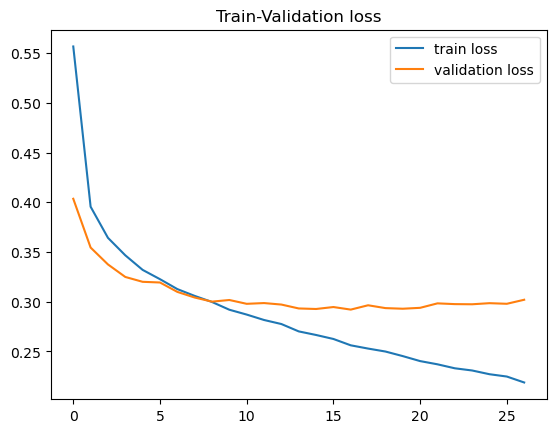

In [19]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8558673469387755, 'precision': 0.8558673469387755, 'f1': 0.8558673469387755, 'accuracy': 0.8558673469387755}
MALE {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333334, 'accuracy': 0.8567708333333334}
FEMALE {'recall': 0.855, 'precision': 0.855, 'f1': 0.855, 'accuracy': 0.855} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6994949494949495, 'precision': 0.6994949494949495, 'f1': 0.6994949494949495, 'accuracy': 0.6994949494949495}
MALE {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}
FEMALE {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6988265971316818, 'precision': 0.6988265971316818, 'f1': 0.6988265971316818, 'accuracy': 0.6988265971316818}
MALE {'recall': 0.70

Resultados finales

In [21]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8596938775510204, 'precision': 0.8596938775510204, 'f1': 0.8596938775510204, 'accuracy': 0.8596938775510204}
Métricas etiqueta male: {'recall': 0.8637152777777778, 'precision': 0.8637152777777778, 'f1': 0.8637152777777778, 'accuracy': 0.8637152777777778}
Métricas etiqueta female:  {'recall': 0.8558333333333333, 'precision': 0.8558333333333333, 'f1': 0.8558333333333333, 'accuracy': 0.8558333333333333}

 to
Resultado global: {'recall': 0.7015993265993266, 'precision': 0.7015993265993266, 'f1': 0.7015993265993266, 'accuracy': 0.7015993265993266}
Métricas etiqueta male: {'recall': 0.7112733171127332, 'precision': 0.7112733171127332, 'f1': 0.7112733171127332, 'accuracy': 0.7112733171127332}
Métricas etiqueta female:  {'recall': 0.6911636045494313, 'precision': 0.6911636045494313, 'f1': 0.6911636045494313, 'accuracy': 0.6911636045494313}

 as
Resultado global: {'recall': 0.6970882225119513, 'precision': 0.6970882225119513, 'f1': 0.6

# TO

In [22]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6947546006287432 	 Validation loss: 0.6945782606884584 	 
  1%|          | 574/57400 [01:29<2:39:26,  5.94it/s]
Epoch 2 	 Training loss: 0.6944296593657769 	 Validation loss: 0.692350144103422 	 
  2%|▏         | 1148/57400 [02:59<2:26:43,  6.39it/s]
Epoch 3 	 Training loss: 0.6943023238032537 	 Validation loss: 0.6925178190409127 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:29<2:28:36,  6.24it/s]
Epoch 4 	 Training loss: 0.6937546816229405 	 Validation loss: 0.6923367522530637 	 
  4%|▍         | 2296/57400 [05:59<2:25:31,  6.31it/s]
Epoch 5 	 Training loss: 0.6940464491628189 	 Validation loss: 0.6940469873153557 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:28<2:23:56,  6.31it/s]
Epoch 6 	 Training loss: 0.6942988232245428 	 Validation loss: 0.6932184140560991 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [08:58<2:12:51,  6.77it/s]
Epoch 7 	 Training loss: 0.6941040843621363 	 Validation loss: 0.6920171612

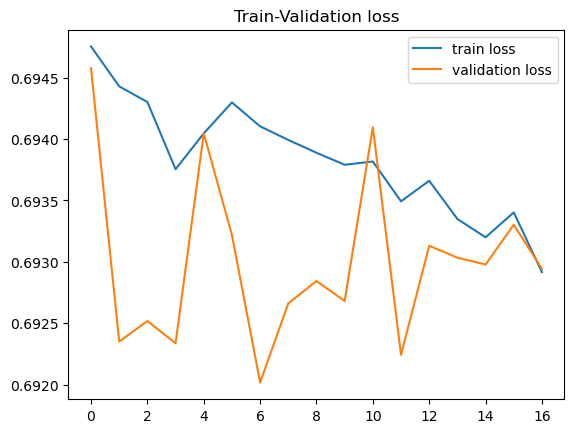

In [23]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5357142857142857, 'precision': 0.5357142857142857, 'f1': 0.5357142857142857, 'accuracy': 0.5357142857142857}
MALE {'recall': 0.11458333333333333, 'precision': 0.11458333333333333, 'f1': 0.11458333333333333, 'accuracy': 0.11458333333333333}
FEMALE {'recall': 0.94, 'precision': 0.94, 'f1': 0.94, 'accuracy': 0.94} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5075757575757576, 'precision': 0.5075757575757576, 'f1': 0.5075757575757576, 'accuracy': 0.5075757575757576}
MALE {'recall': 0.12895377128953772, 'precision': 0.12895377128953772, 'f1': 0.12895377128953772, 'accuracy': 0.12895377128953772}
FEMALE {'recall': 0.916010498687664, 'precision': 0.916010498687664, 'f1': 0.916010498687664, 'accuracy': 0.916010498687664} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5045632333767927, 'precision': 0.5045632333767927, 'f1': 0.5045632333767927, 'accuracy': 0.5045632333767927}
MALE {'recall': 0.09

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935157915025638 	 Validation loss: 0.6922770607269416 	 
  1%|          | 574/57400 [01:29<2:21:40,  6.69it/s]
Epoch 2 	 Training loss: 0.69316786444561 	 Validation loss: 0.6936951067488072 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [02:58<2:27:36,  6.35it/s]
Epoch 3 	 Training loss: 0.6934404918333379 	 Validation loss: 0.6929895887940617 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:27<2:17:28,  6.75it/s]
Epoch 4 	 Training loss: 0.6934962310026747 	 Validation loss: 0.6926102567527254 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [05:56<2:19:48,  6.57it/s]
Epoch 5 	 Training loss: 0.6932697124805185 	 Validation loss: 0.6924789103411012 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [07:26<2:16:10,  6.67it/s]
Epoch 6 	 Training loss: 0.6932173351585242 	 Validation loss: 0.6926925273264869 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [08:55<2:20:03,  6.42it/s]
Epoch 7 	 Training

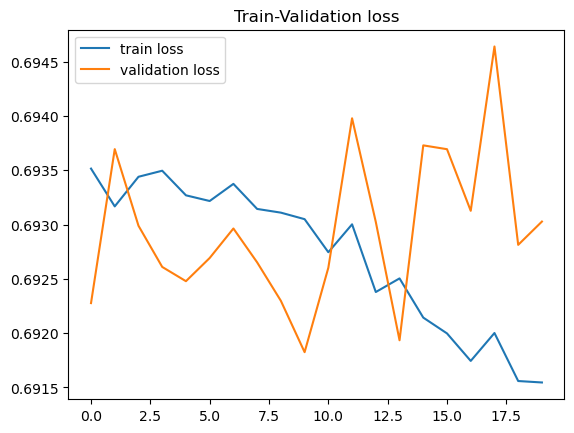

In [25]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5178571428571429, 'precision': 0.5178571428571429, 'f1': 0.5178571428571429, 'accuracy': 0.5178571428571429}
MALE {'recall': 0.21354166666666666, 'precision': 0.21354166666666666, 'f1': 0.21354166666666666, 'accuracy': 0.21354166666666666}
FEMALE {'recall': 0.81, 'precision': 0.81, 'f1': 0.81, 'accuracy': 0.81} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5416666666666666, 'precision': 0.5416666666666666, 'f1': 0.5416666666666666, 'accuracy': 0.5416666666666666}
MALE {'recall': 0.22871046228710462, 'precision': 0.22871046228710462, 'f1': 0.22871046228710462, 'accuracy': 0.22871046228710462}
FEMALE {'recall': 0.8792650918635171, 'precision': 0.8792650918635171, 'f1': 0.8792650918635171, 'accuracy': 0.8792650918635171} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5541069100391134, 'precision': 0.5541069100391134, 'f1': 0.5541069100391134, 'accuracy': 0.5541069100391134}
MALE {'recall': 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938664308823775 	 Validation loss: 0.693372023307671 	 
  1%|          | 574/57400 [01:32<2:23:47,  6.59it/s]
Epoch 2 	 Training loss: 0.6936660059030048 	 Validation loss: 0.6938924274202121 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:04<2:18:59,  6.75it/s]
Epoch 3 	 Training loss: 0.6934632632998224 	 Validation loss: 0.6922277636447195 	 
  3%|▎         | 1722/57400 [04:36<2:18:08,  6.72it/s]
Epoch 4 	 Training loss: 0.693547005022029 	 Validation loss: 0.692741409196692 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:08<2:16:05,  6.75it/s]
Epoch 5 	 Training loss: 0.6937132858856214 	 Validation loss: 0.6934801279488256 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [07:40<2:10:35,  6.96it/s]
Epoch 6 	 Training loss: 0.6936801913930979 	 Validation loss: 0.6927258695586253 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:11<2:17:49,  6.52it/s]
Epoch 7 	 Training loss: 0.6934390095052819 	 Va

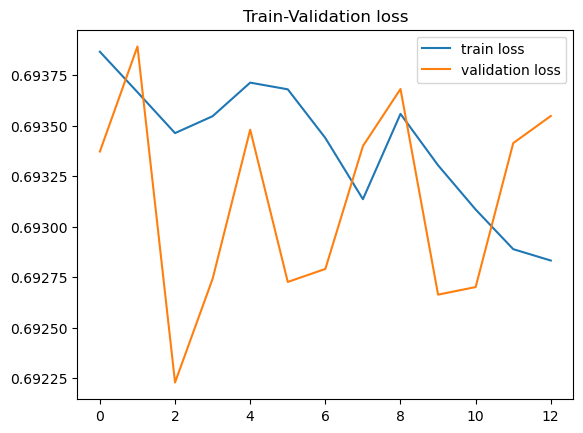

In [27]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



Resultados finales

In [29]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5212585034013606, 'precision': 0.5212585034013606, 'f1': 0.5212585034013606, 'accuracy': 0.5212585034013606}
Métricas etiqueta male: {'recall': 0.109375, 'precision': 0.109375, 'f1': 0.109375, 'accuracy': 0.109375}
Métricas etiqueta female:  {'recall': 0.9166666666666666, 'precision': 0.9166666666666666, 'f1': 0.9166666666666666, 'accuracy': 0.9166666666666666}

 to
Resultado global: {'recall': 0.51010101010101, 'precision': 0.51010101010101, 'f1': 0.51010101010101, 'accuracy': 0.51010101010101}
Métricas etiqueta male: {'recall': 0.11922141119221412, 'precision': 0.11922141119221412, 'f1': 0.11922141119221412, 'accuracy': 0.11922141119221412}
Métricas etiqueta female:  {'recall': 0.931758530183727, 'precision': 0.931758530183727, 'f1': 0.931758530183727, 'accuracy': 0.931758530183727}

 as
Resultado global: {'recall': 0.5141242937853107, 'precision': 0.5141242937853107, 'f1': 0.5141242937853107, 'accuracy': 0.5141242937853107}

# AS

In [30]:
learning_rate = 1e-6
num_epochs = 100
global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935021356007779 	 Validation loss: 0.6925222186718957 	 
  1%|          | 574/57400 [01:32<2:36:59,  6.03it/s]
Epoch 2 	 Training loss: 0.6933197777861086 	 Validation loss: 0.6931721931796962 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:04<2:24:17,  6.50it/s]
Epoch 3 	 Training loss: 0.692926735931988 	 Validation loss: 0.6925353135092783 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:36<2:22:50,  6.50it/s]
Epoch 4 	 Training loss: 0.6918308199075041 	 Validation loss: 0.6924194117723885 	 
  4%|▍         | 2296/57400 [06:08<2:16:23,  6.73it/s]
Epoch 5 	 Training loss: 0.688999600007559 	 Validation loss: 0.6912485492431512 	 
  5%|▌         | 2870/57400 [07:40<2:25:23,  6.25it/s]
Epoch 6 	 Training loss: 0.6870320271116516 	 Validation loss: 0.6936424808987116 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:12<2:14:47,  6.67it/s]
Epoch 7 	 Training loss: 0.6859134944473825 	 Validation loss: 0.69195123143

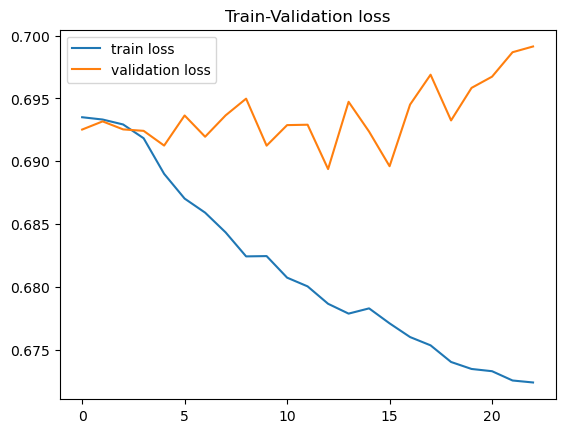

In [31]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6913265306122449, 'precision': 0.6913265306122449, 'f1': 0.6913265306122449, 'accuracy': 0.6913265306122449}
MALE {'recall': 0.7057291666666666, 'precision': 0.7057291666666666, 'f1': 0.7057291666666666, 'accuracy': 0.7057291666666666}
FEMALE {'recall': 0.6775, 'precision': 0.6775, 'f1': 0.6775, 'accuracy': 0.6775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7348484848484849, 'precision': 0.7348484848484849, 'f1': 0.7348484848484848, 'accuracy': 0.7348484848484849}
MALE {'recall': 0.805352798053528, 'precision': 0.805352798053528, 'f1': 0.805352798053528, 'accuracy': 0.805352798053528}
FEMALE {'recall': 0.6587926509186351, 'precision': 0.6587926509186351, 'f1': 0.6587926509186351, 'accuracy': 0.6587926509186351} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7744458930899609, 'precision': 0.7744458930899609, 'f1': 0.7744458930899609, 'accuracy': 0.7744458930899609}
MALE {'recall': 0.75

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936652729943239 	 Validation loss: 0.692578594563371 	 
  1%|          | 574/57400 [01:31<2:22:35,  6.64it/s]
Epoch 2 	 Training loss: 0.6931205783363834 	 Validation loss: 0.6931291333699631 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:03<2:16:56,  6.85it/s]
Epoch 3 	 Training loss: 0.6916223911873555 	 Validation loss: 0.6922183097419092 	 
  3%|▎         | 1722/57400 [04:35<2:21:29,  6.56it/s]
Epoch 4 	 Training loss: 0.6886635933603559 	 Validation loss: 0.6915799854165416 	 
  4%|▍         | 2296/57400 [06:06<2:17:16,  6.69it/s]
Epoch 5 	 Training loss: 0.6867925022121921 	 Validation loss: 0.6884611420712229 	 
  5%|▌         | 2870/57400 [07:38<2:29:39,  6.07it/s]
Epoch 6 	 Training loss: 0.6850773992231083 	 Validation loss: 0.6893313506902274 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:10<2:21:58,  6.33it/s]
Epoch 7 	 Training loss: 0.683846813461091 	 Validation loss: 0.6933182255696442 	 

2 epoch without imp

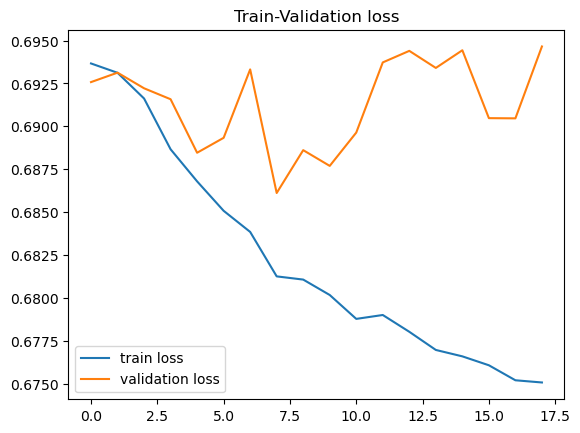

In [33]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6670918367346939, 'precision': 0.6670918367346939, 'f1': 0.6670918367346939, 'accuracy': 0.6670918367346939}
MALE {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}
FEMALE {'recall': 0.6675, 'precision': 0.6675, 'f1': 0.6675, 'accuracy': 0.6675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7537878787878788, 'precision': 0.7537878787878788, 'f1': 0.7537878787878789, 'accuracy': 0.7537878787878788}
MALE {'recall': 0.8077858880778589, 'precision': 0.8077858880778589, 'f1': 0.8077858880778589, 'accuracy': 0.8077858880778589}
FEMALE {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7979139504563233, 'precision': 0.7979139504563233, 'f1': 0.7979139504563233, 'accuracy': 0.7979139504563233}
MALE {'recall': 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6942684288016595 	 Validation loss: 0.6926201965849278 	 
  1%|          | 574/57400 [01:30<2:35:58,  6.07it/s]
Epoch 2 	 Training loss: 0.6937426761675379 	 Validation loss: 0.6924808005155143 	 
  2%|▏         | 1148/57400 [03:02<2:19:46,  6.71it/s]
Epoch 3 	 Training loss: 0.6929552923719227 	 Validation loss: 0.6914018857277046 	 
  3%|▎         | 1722/57400 [04:33<2:23:24,  6.47it/s]
Epoch 4 	 Training loss: 0.6900117398346758 	 Validation loss: 0.6918260687488621 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:04<2:11:57,  6.96it/s]
Epoch 5 	 Training loss: 0.6877423608967651 	 Validation loss: 0.6902633471004034 	 
  5%|▌         | 2870/57400 [07:35<2:22:38,  6.37it/s]
Epoch 6 	 Training loss: 0.6864266227346679 	 Validation loss: 0.6908389632984743 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:05<2:15:19,  6.65it/s]
Epoch 7 	 Training loss: 0.6849041304937223 	 Validation loss: 0.6901540432946157 	 
  7%|▋         | 4

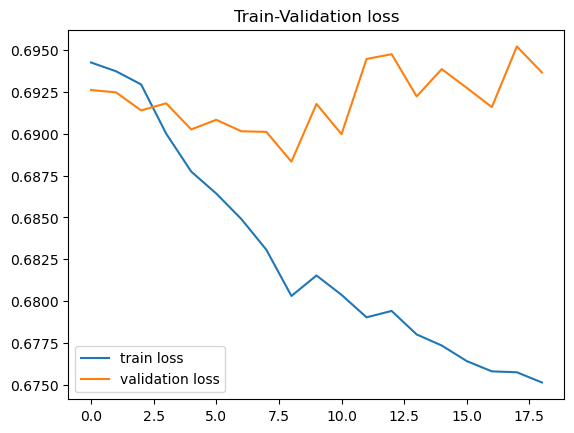

In [35]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_roberta_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7193877551020408, 'precision': 0.7193877551020408, 'f1': 0.7193877551020408, 'accuracy': 0.7193877551020408}
MALE {'recall': 0.6796875, 'precision': 0.6796875, 'f1': 0.6796875, 'accuracy': 0.6796875}
FEMALE {'recall': 0.7575, 'precision': 0.7575, 'f1': 0.7575, 'accuracy': 0.7575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7563131313131313, 'precision': 0.7563131313131313, 'f1': 0.7563131313131313, 'accuracy': 0.7563131313131313}
MALE {'recall': 0.8004866180048662, 'precision': 0.8004866180048662, 'f1': 0.8004866180048662, 'accuracy': 0.8004866180048662}
FEMALE {'recall': 0.7086614173228346, 'precision': 0.7086614173228346, 'f1': 0.7086614173228346, 'accuracy': 0.7086614173228346} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7848761408083442, 'precision': 0.7848761408083442, 'f1': 0.7848761408083442, 'accuracy': 0.7848761408083442}
MALE {'recall': 0.7575757575757576, 'precision': 0.7

Resultados finales

In [37]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6926020408163265, 'precision': 0.6926020408163265, 'f1': 0.6926020408163265, 'accuracy': 0.6926020408163265}
Métricas etiqueta male: {'recall': 0.6840277777777778, 'precision': 0.6840277777777778, 'f1': 0.6840277777777778, 'accuracy': 0.6840277777777778}
Métricas etiqueta female:  {'recall': 0.7008333333333333, 'precision': 0.7008333333333333, 'f1': 0.7008333333333333, 'accuracy': 0.7008333333333333}

 to
Resultado global: {'recall': 0.7483164983164983, 'precision': 0.7483164983164983, 'f1': 0.7483164983164983, 'accuracy': 0.7483164983164983}
Métricas etiqueta male: {'recall': 0.8045417680454177, 'precision': 0.8045417680454177, 'f1': 0.8045417680454177, 'accuracy': 0.8045417680454177}
Métricas etiqueta female:  {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506}

 as
Resultado global: {'recall': 0.7857453281182095, 'precision': 0.7857453281182095, 'f1': 0.7